In [11]:
%matplotlib inline
import numpy as np
import torch
from src.M_torch import M_torch
import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.colors as colors
plt.style.use('default')

In [12]:
#Field parameters
Nc = 3 #Field revolutions in envelope
eps = 0 #(-1,0,1), Polarization of light
phi = 0 #Phase difference between envelope and field
#all values in au
wl = 1/4*0.057 #800nm wavelength
I = 0.003 #I=10^14 w/cm^2  
E0 = -0.500 #13.6 eV
res = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # Uncomment this line to force CPU usage
M1 = M_torch(Nc, eps, phi, wl, I, E0, res, device=device)

Using device: cuda


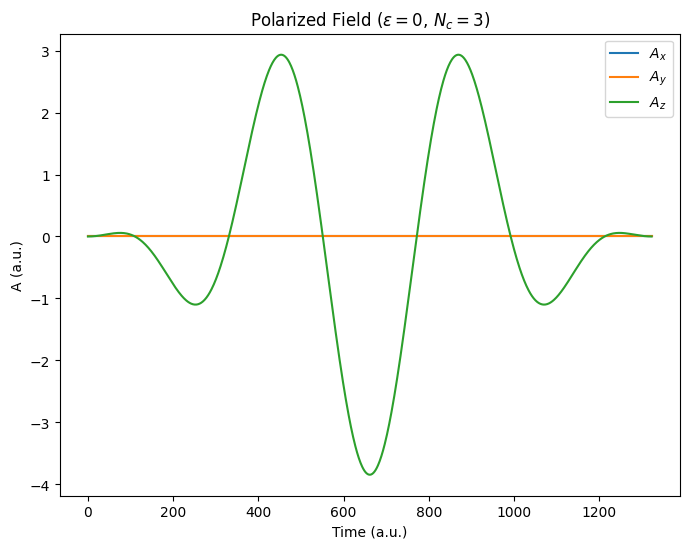

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('A (a.u.)')
A = M1.As
ax.plot(M1.ts.cpu().numpy(), A[0].cpu().numpy(), label='$A_x$')
ax.plot(M1.ts.cpu().numpy(), A[1].cpu().numpy(), label='$A_y$')
ax.plot(M1.ts.cpu().numpy(), A[2].cpu().numpy(), label='$A_z$')
ax.set_title(r"Polarized Field ($\epsilon=$" + f"{eps}" + r", $N_c=$" + f"{Nc})")
ax.legend()

In [14]:
# Define grid ranges and resolution
k_start = -2
k_end = 2
num_steps = 200
kxs = torch.linspace(k_start, k_end, steps=num_steps, device=device)
kys = torch.linspace(k_start, k_end, steps=num_steps, device=device)
kzs = torch.linspace(k_start, k_end, steps=num_steps, device=device)

# Create meshgrid
kxs_grid, kys_grid, kzs_grid = torch.meshgrid(kxs, kys, kzs, indexing='ij')

# Stack and reshape to (N, 3)
ks = torch.stack([kxs_grid, kys_grid, kzs_grid], dim=-1).reshape(-1, 3)

print(r'ks size:', ks.shape)

ks size: torch.Size([8000000, 3])


In [15]:
k_test_torch = torch.tensor([[0.0, 0.0, 0.5]], device=device, dtype=torch.float64)
print("PyTorch Mk0_squared:", M1.Mk0_squared(k_test_torch).cpu().numpy())

PyTorch Mk0_squared: [157.40159801]


In [16]:
batch_size = 5000 
Mk_squared_vals = []

with torch.no_grad():
    # Calculate Mk_squared in batches
    for i in range(0, ks.shape[0], batch_size):
        ks_batch = ks[i:i+batch_size]
        Mk_batch = M1.Mk0_squared(ks_batch)
        Mk_squared_vals.append(Mk_batch.cpu())  # Move to CPU to free GPU memory

Mk_squared_vals = torch.cat(Mk_squared_vals)
Mk_squared_vals = Mk_squared_vals.reshape(kxs_grid.shape)

#Normalize the values to the range [0, 1]
Mk_squared_vals = Mk_squared_vals / Mk_squared_vals.max()


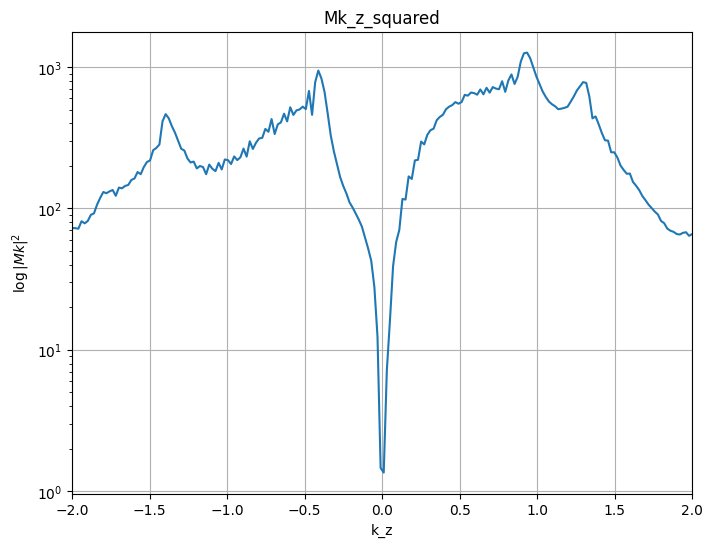

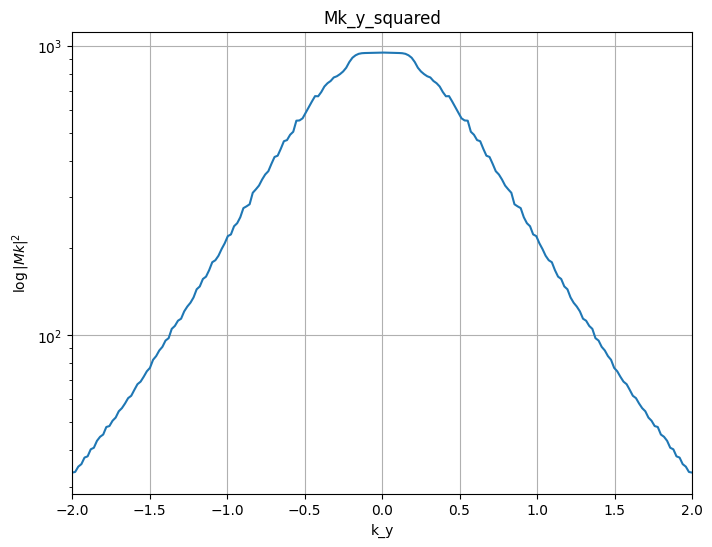

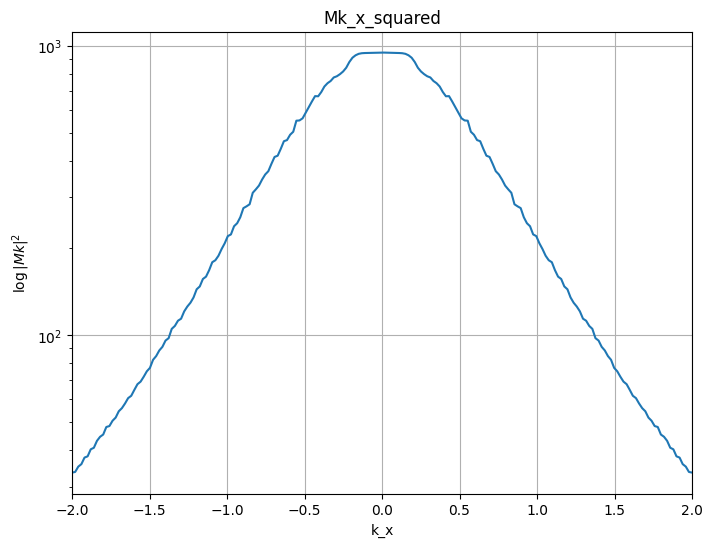

In [17]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax.set_title('Mk_squared')
# ax.set_xlabel('k_z')
# ax.set_ylabel(r'$|Mk|^2$')
# ax.set_xlim(-2.0, 2.0)
# # Get the middle index for kx and ky (where they are closest to 0)
# mid_idx = num_steps // 2
# ax.plot(kzs.cpu().numpy(), Mk_squared_vals[mid_idx, mid_idx, :].cpu().numpy(), label='$k_x=0$, $k_y=0$')
# ax.set_yscale('log')  # Set y-axis to logarithmic scale
# ax.grid(True)
# ax.legend()

# project the 3d data onto the z axis to get Mk_z_squared
Mk_z_squared = torch.sum(Mk_squared_vals, dim=(0, 1))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title('Mk_z_squared')
ax.set_xlabel('k_z')
ax.set_ylabel(r'$\log{|Mk|^2}$')
ax.plot(kzs.cpu().numpy(), Mk_z_squared.cpu().numpy(), label='$Mk_z^2$')
ax.set_yscale('log')  # Set y-axis to logarithmic scale
ax.set_xlim(-2.0, 2.0)
ax.grid(True)

# project the 3d data onto the y axis to get Mk_y_squared
Mk_y_squared = torch.sum(Mk_squared_vals, dim=(0, 2))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title('Mk_y_squared')
ax.set_xlabel('k_y')
ax.set_ylabel(r'$\log{|Mk|^2}$')
ax.plot(kys.cpu().numpy(), Mk_y_squared.cpu().numpy(), label='$Mk_y^2$')
ax.set_yscale('log')  # Set y-axis to logarithmic scale
ax.set_xlim(-2.0, 2.0)
ax.grid(True)

# project the 3d data onto the y axis to get Mk_x_squared
Mk_x_squared = torch.sum(Mk_squared_vals, dim=(1, 2))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title('Mk_x_squared')
ax.set_xlabel('k_x')
ax.set_ylabel(r'$\log{|Mk|^2}$')
ax.plot(kxs.cpu().numpy(), Mk_x_squared.cpu().numpy(), label='$Mk_x^2$')
ax.set_yscale('log')  # Set y-axis to logarithmic scale
ax.set_xlim(-2.0, 2.0)
ax.grid(True)


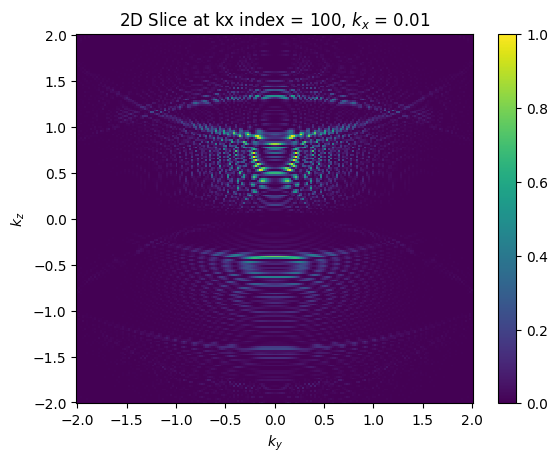

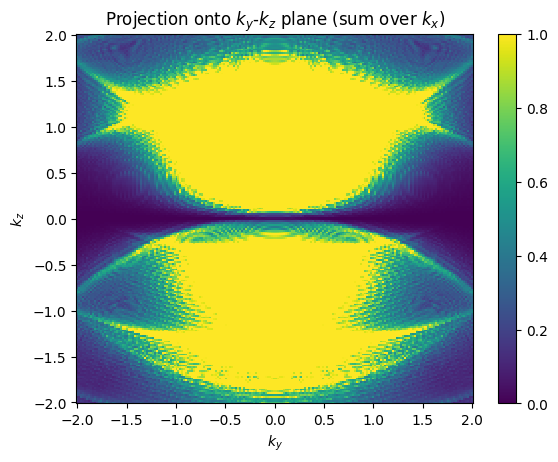

In [18]:

fig0, ax0 = plt.subplots()

def plot_2d_slice(kx_val):
    ax0.clear()
    # Create a 2D slice of the data
    slice_data = Mk_squared_vals[kx_val, :, :].cpu().numpy()
    kys_slice = kys_grid[kx_val, :, :].cpu().numpy()
    kzs_slice = kzs_grid[kx_val, :, :].cpu().numpy()

    # Plot the 2D slice
    c = ax0.pcolormesh(kys_slice, kzs_slice, slice_data, shading='auto',norm=colors.Normalize(vmin=0, vmax=1), cmap='viridis')
    ax0.set_title(f'2D Slice at kx index = {round(kx_val)}, $k_x$ = {kxs[kx_val].item():.2f}')

    ax0.set_xlabel('$k_y$')
    ax0.set_ylabel('$k_z$')
    fig0.colorbar(c, ax=ax0)
    # # Remove previous colorbars if any
    # if hasattr(plot_2d_slice, 'colorbar') and plot_2d_slice.colorbar:
    #     plot_2d_slice.colorbar.remove()
    # plot_2d_slice.colorbar = fig.colorbar(c, ax=ax)

# # Initialize colorbar attribute
# plot_2d_slice.colorbar = None
fig, ax = plt.subplots()
def plot_projected_density():
    ax.clear()
    # Sum over kx axis to project onto the (ky, kz) plane
    projected = Mk_squared_vals.sum(dim=0).cpu().numpy()
    kys_2d = kys_grid[0, :, :].cpu().numpy()
    kzs_2d = kzs_grid[0, :, :].cpu().numpy()
    c = ax.pcolormesh(kys_2d, kzs_2d, projected, shading='auto', norm=colors.Normalize(vmin=0, vmax=1), cmap='viridis')
    ax.set_title('Projection onto $k_y$-$k_z$ plane (sum over $k_x$)')
    ax.set_xlabel('$k_y$')
    ax.set_ylabel('$k_z$')
    fig.colorbar(c, ax=ax)

# Call the function to display the projected density plot
plot_projected_density()

# # Create a slider for kx
# kx_slider = widgets.IntSlider(value=num_steps//2, min=0, max=kxs_grid.shape[0]-1, step=1, description='kx index')
# out = widgets.interact_manual(plot_2d_slice, kx_val=kx_slider)

# #Display the initial plot
# plot_2d_slice(num_steps//2)
# display(out)

# Create a slice for the x y plane at kz=0
plot_2d_slice(num_steps//2)



In [19]:
from matplotlib import animation


# Flatten everything for easy masking
kxs_flat = kxs_grid.flatten()
kys_flat = kys_grid.flatten()
kzs_flat = kzs_grid.flatten()
Mk_flat = Mk_squared_vals.flatten()

# mask_slider = widgets.FloatSlider(
#     value=threshold,
#     min=0.0,
#     max=Mk_squared_vals.max().item(),
#     step=0.1,
#     description='Threshold',
#     continuous_update=False,
#     readout_format='.2f',
# )
# # Create mask for values above threshold

# fig = plt.figure(layout='constrained')
# ax = fig.add_subplot(111, projection='3d')
# threshold_line = None
# cbar = None  # Initialize cbar as None

# def update_plot(threshold):
#     global threshold_line, cbar
#     ax.cla()  # Clear the previous plot

#     # Remove previous threshold line if it exists
#     if threshold_line is not None:
#         try:
#             threshold_line.remove()
#         except Exception:
#             pass
#         threshold_line = None

#     mask = Mk_flat > threshold
#     # Plot only the points above threshold
#     sc = ax.scatter(
#         kxs_flat[mask].cpu(), kys_flat[mask].cpu(), kzs_flat[mask].cpu(),
#         c=Mk_flat[mask].cpu(), cmap='viridis', marker='o', alpha=0.3, s=10
#     )
#     ax.set_xlim([-1, 1])
#     ax.set_ylim([-1, 1])
#     ax.set_zlim([-1, 1])
#     ax.set_xlabel('kx')
#     ax.set_ylabel('ky')
#     ax.set_zlabel('kz')
#     ax.set_title('3D Momentum Space (Thresholded)')
#     # Draw the threshold line and keep a reference to it
#     if cbar is not None:
#         threshold_line = cbar.ax.axhline(threshold, color='red', linewidth=2)
#     return sc

# sc = update_plot(threshold)
# cbar = fig.colorbar(sc, ax=ax, label=r'$|Mk|^2$')
# update_plot(threshold)  # Redraw with cbar available


# # # out_3d = widgets.interact_manual(update_plot, threshold=mask_slider)
# # # Display the initial plot
# # update_plot(threshold)
# # # display(out_3d)

# # def animate_threshold(i):
# #     t = i / 9  # 10 frames, t goes from 0 to 1
# #     threshold = t
# #     update_plot(threshold)
# #     return ax,

# # ani = animation.FuncAnimation(
# #     fig, animate_threshold, frames=10, interval=500, blit=False, repeat=True
# # )
# # ani.save('momentum_space_threshold.gif', writer='pillow', fps=2)
# # plt.show()


(<mpl_toolkits.mplot3d.art3d.Path3DCollection at 0x24bdbd7b890>,)

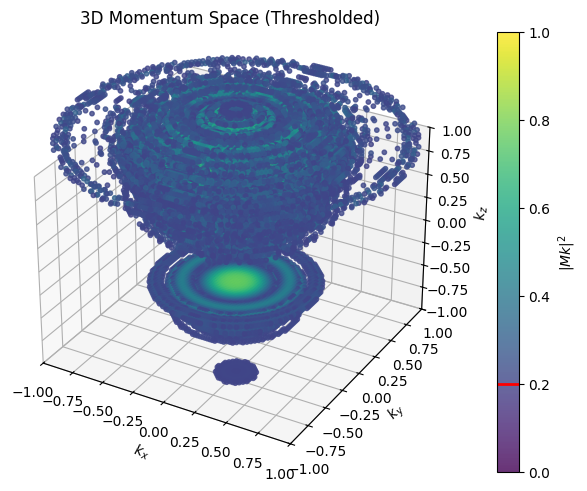

In [20]:
threshold = 0.2 # or any value you want

# Create a new figure and 3D axes for the scatter plot
fig3d = plt.figure(layout='constrained')
ax3d = fig3d.add_subplot(111, projection='3d')
ax3d.set_title('3D Momentum Space (Thresholded)')
ax3d.set_xlabel('$k_x$')
ax3d.set_ylabel('$k_y$')
ax3d.set_zlabel('$k_z$')
ax3d.set_xlim([-1, 1])
ax3d.set_ylim([-1, 1])
ax3d.set_zlim([-1, 1])
# Initial plot
mask = Mk_flat > threshold
sc = ax3d.scatter(
    kxs_flat[mask].cpu(), kys_flat[mask].cpu(), kzs_flat[mask].cpu(),
    c=Mk_flat[mask].cpu(), cmap='viridis', s=10, alpha=0.8, norm=colors.Normalize(vmin=0, vmax=1)
)
cbar = fig3d.colorbar(sc, ax=ax3d, label=r'$|Mk|^2$', norm=colors.Normalize(vmin=0, vmax=1))
threshold_line = cbar.ax.axhline(threshold, color='red', linewidth=2)

def update_plot(threshold):
    global threshold_line
    mask = Mk_flat > threshold
    sc._offsets3d = (
        kxs_flat[mask].cpu().numpy(),
        kys_flat[mask].cpu().numpy(),
        kzs_flat[mask].cpu().numpy()
    )
    sc.set_array(Mk_flat[mask].cpu().numpy())
    # Remove and redraw threshold line
    for l in cbar.ax.lines:
        l.remove()
    cbar.ax.axhline(threshold, color='red', linewidth=2)
    return sc,

update_plot(threshold)  # Initial plot

# ani = animation.FuncAnimation(
#     fig3d, update_plot, frames=np.linspace(0, 1, 10), interval=500, blit=False, repeat=True
# )
# ani.save('momentum_space_threshold.gif', writer='pillow', fps=2)